# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [14]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

In [15]:
batch_vectorizer

artm.BatchVectorizer(data_path="school_batches", num_batches=5)

В следующий раз данные можно считывать уже из батчей:

In [16]:
#batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [17]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1})
# число после названия модальностей - это их веса

In [21]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batch_vectorizer.data_path)

In [22]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               #use_unigram_document_model=False,
                                               dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [23]:
#model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)

Создаем словарь и инициализируем модель с его помощью

In [25]:
model_artm.initialize(dictionary=dictionary)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [27]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

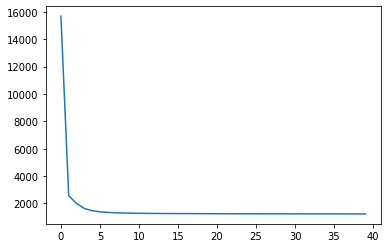

In [28]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [45]:
for topic_name in model_artm.topic_names:
    print( topic_name + ': ',)
    print(','.join(model_artm.score_tracker["top_words"].tokens[-1][topic_name]),)



sbj0: 
быть,право,который,ребенок,человек,язык,они,семья,это,русский,время,для,также,свой,что
sbj1: 
что,свой,который,быть,это,человек,этот,его,герой,она,они,жизнь,ребенок,как,такой
sbj2: 
предложение,слово,который,что,например,это,как,быть,или,речь,такой,они,если,мочь,этот
sbj3: 
который,что,ядро,это,этот,энергия,вода,земля,быть,масса,атом,как,температура,такой,океан
sbj4: 
поэт,пушкин,что,стихотворение,который,свой,это,быть,звук,этот,весь,лирика,год,его,произведение
sbj5: 
x,быть,a,b,число,этот,при,функция,уравнение,что,это,для,если,сила,ток
sbj6: 
который,человек,свой,что,жизнь,его,быть,герой,это,как,произведение,литература,этот,для,русский
sbj7: 
который,человек,общество,развитие,социальный,государство,как,политический,быть,это,себя,культура,жизнь,такой,отношение
sbj8: 
страна,государство,население,который,быть,территория,этот,год,являться,город,африка,время,что,также,хозяйство
sbj9: 
быть,который,год,государство,война,становиться,свой,что,весь,первый,военный,как,время,период,импер

Давайте посмотрим также на разреженность матриц:

In [46]:
print( model_artm.score_tracker["SparsityPhiScore"].last_value)
print( model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7677122950553894
0.0018907563062384725


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [48]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [50]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [51]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [53]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [55]:
for topic_name in model_artm.topic_names:
    print( topic_name + ': ',)
    print(','.join(model_artm.score_tracker["top_words"].tokens[-1][topic_name]),)




sbj0: 
право,ребенок,язык,свобода,семья,английский,религиозный,гражданский,быт,суд,воспитание,честь,орган,the,закреплять
sbj1: 
жить,повесть,женщина,нет,поэма,лермонтов,написать,школа,молодой,сказка,отец,хороший,любить,гоголь,умирать
sbj2: 
слово,например,предложение,простой,какой,речь,предмет,глагол,скорость,физика,имя,выступать,свет,кто,среда
sbj3: 
земля,энергия,вода,ядро,масса,движение,природный,состоять,океан,частица,атом,заряд,температура,располагать,южный
sbj4: 
пушкин,поэт,стихотворение,звук,лирика,писать,стих,поэзия,сравнение,почти,ночь,русь,былина,красота,любовный
sbj5: 
при,x,a,сила,если,два,число,можно,b,функция,пример,получать,тело,равный,случай
sbj6: 
человек,его,жизнь,герой,русский,главный,произведение,мир,литература,сам,история,автор,литературный,личность,всегда
sbj7: 
общество,представлять,развитие,отношение,социальный,политический,процесс,форма,система,экономический,производство,культура,характер,понятие,роль
sbj8: 
страна,территория,население,город,древний,северный,м

In [57]:
# еще раз посмотрим на разреженность
print( model_artm.score_tracker["SparsityPhiScore"].last_value)
print( model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9007267355918884
0.09810924530029297


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [58]:
model_artm.save("my_model")

In [59]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [60]:
phi = model_artm.get_phi()

In [61]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
пластинка,0.0,0.000000,0.000000,0.000092,0.000000,0.000000,0.0,0.0,0.0,0.0
фотопластинка,0.0,0.000000,0.000000,0.000184,0.000000,0.000000,0.0,0.0,0.0,0.0
Добросклонова,0.0,0.000138,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
лирикиОсобенно,0.0,0.000138,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
вправе,0.0,0.000138,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
кинетический,0.0,0.000000,0.000000,0.002209,0.000000,0.000000,0.0,0.0,0.0,0.0
спроецировать,0.0,0.000000,0.000000,0.000000,0.000000,0.000053,0.0,0.0,0.0,0.0
соотноситься,0.0,0.000000,0.000128,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
эпицентр,0.0,0.000000,0.000000,0.000000,0.000243,0.000000,0.0,0.0,0.0,0.0


Матрица вероятностей тем в документах.

In [67]:
#artm.ARTM.cache_theta = True
theta = model_artm.get_theta()
theta

""


In [69]:
model_artm.get_theta_sparse()

E0331 22:08:52.655010 54322688 c_interface.cc:59] InternalError :  theta_matrix->topic_indices_size() == 0


InternalError: theta_matrix->topic_indices_size() == 0

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [66]:
theta_test = model_artm.transform(batch_vectorizer)